
# **Laboratorio No. 3**

**FasterRCNN:Detectando objetos en video**


<font color='GREEN'>Integrantes:
* Sebastian Botero   2205892
* Miguel Saavedra    2205805
* Gustavo Salazar    2205363

Para los que desean más información acerca del tema:


1. Paper de Faster RCNN https://arxiv.org/pdf/1506.01497.pdf
2. Paper de RCNN https://arxiv.org/pdf/1311.2524.pdf
3. Algunos paginas con githubs con la implementación de FasterRCNN


*   https://www.kaggle.com/kishor1210/train-faster-rcnn-using-keras
* https://github.com/kentaroy47/frcnn-from-scratch-with-keras
* https://github.com/you359/Keras-FasterRCNN
* https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55


**Paso 1.**
<font color='green'>Entrenando una FasterRCNN</font>
Haga uso de los diferentes archivos utilizados en clase para:
1. **Crear un dataset de 3 clases.** Usted puede hacer uso del Dataset de google: Open Images, para crear su propio dataset, escogiendo libremente 3 clases de diferentes objetos. Una recomendación es utilizar un numero considerable de imagenes. e.g, 1000 imagenes.
2. Entrenar la red. 
3. Validar la red.

 **Nota:** Tenga en cuenta que colab solo le permite 12.7 GB de RAM y al parecer este código esta usando (de manera equivocada) una gran cantidad para el entrenamiento. Les sugiero entrenar de a 7 epocas y reiniciar el entorno de ejecución. Es posible que si deja agotar completamente la memoria, el archivo del modelo que esta guardando se dañe. Colab ademas puede bloquear su cuenta para uso con GPU por un espacio de 12 horas. Es por estas razones que este laboratorio se podrá entregar una semana antes de finalizar el curso (Tenga en cuenta la fecha límite fijada en classroom).

# **Ejercicio 1.** 
<font color='blue'>Red entrenada</font>
Salve un archivo con los pesos obtenidos del entrenamiento.
Cree una carpeta que debe ser posteriormente ser enviada al docente. Cree un sobfolder, llamado "*Entrenamiento*" y deposite en esta carpeta lo siguiente:
* <font color='green'>El archivo de pesos del entrenamiento realizado.</font>
* <font color='green'>Graficos que muestren las metricas obtenidas del entrenamiento (ambas redes y ambas salidas) junto con una explicación acerca de los resultados obtenidos.</font>
* <font color='green'>Al menos 10 imagenes que muestren los resultados obtenidos (bbox) sobre el dataset de validación.</font>





**Paso 2.** <font color='green'>(Opcional)  Detección sobre video</font>

<font color='blue'> Este paso junto con el ejercicio 2 no son obligatorios. Si su grupo decide hacerlo y el resultado obtenido es "correcto", el grupo tendrá +1.0 pts sobre la nota del primer parcial o del laboratorio 1 o 2.</font>

Demuestre las bondades de su red, para detectar al menos una de las clases que usted escogió, sobre un video corto. Usted puede hacer una busqueda en internet (e.g., videos de youtube y usar herramientas online para crear un sub-clip de maximo 10 segundos), o crear uno propio.

**Nota**: Es claro que google colab, no permite ejecutar los videos on-line. Usted deberá crear un programa (e.g, usando opencv) que lea el video frame a frame y realizar las predicciones sobre cada uno de estos frame. Los frames con bbox, deben ser de nuevo convertidos a un archivo de video.


#</font><font color='blue'> **Ejercicio 2.**</font>

**Cree una subfolder llamado "*Video*", dentro de la  carpeta que enviará al docente y deposite el video previamente creado con los resultados obtenidos**

<font color='green'>**Video: guitar_processed_video.mp4**</font>


# </font><font color='blue'> **Ejercicio 3.**</font>

**Teoría detrás del código de FasterRCNN utilizado**

Aunque para un curso relativamente corto, es imposible realizar completamente la codificación de una FasterRCNN. Algunos conceptos pueden ser utiles para entender y seguir el código de una manera más fácil.
Responda las siguientes 4 preguntas: 


## <font color='green'>**Pregunta 1.**</font>
 En la función </font><font color='blue'>*classifier_layer()*</font> se utiliza una capa contenedora llamada <font color='blue'>*TimeDistributed*</font>.  Como por ejemplo en la siguiente linea:</font><font color='blue'>*out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)*</font>

<font color='green'>¿Que es y para que sirve Time Distributed? ¿Porque es obligatorio usarlo dentro de la capa clasificadora? Realize un grafico de flujo entrada/salida de esta capa clasificadora, que permita aclarar su respuesta.</font>




<font color='blue'> ¿Que es y para que sirve Time Distributed? </font> 

La capa `Time Distributed` de Keras permite aplicar una capa, por ejemplo Dense o Conv2D, a un arreglo de datos (al menos 3D) de tal manera de que aplica la misma operación sobre los diferentes indices temporales de la señal. Para Keras, dicho índice se encuentra en la posición 1 del arreglo de datos.

Para entender este concepto mejor, suponga que se cuenta con 10 muestras de videos `[batch]`, con tamaño de imagen `32x32` RGB donde se tomaron 15 imágenes diferentes a lo largo de un tiempo `time`. El arreglo de datos tendría la siguiente forma `[batch, time, width, length, channel]`.

Para este caso anterior, lo idóneo sería aplicar la misma operación (`Conv2D`) a cada una de las muestras a lo largo del tiempo de manera independiente. Es aquí donde `Time Distributed` entra en acción y aplica la operación `Conv2D`, con los mismos pesos, sobre los `15` timestamps especificados y produciendo un arreglo final de salida de tamaño `[batch, time, width, length, channel]`. Cabe resaltar que siempre que se desee aplicar una capa sobre una dimensión de tiempo (y conservar dicha dimensión intacta) se debe utilizar `Time Distributed`.



<font color='blue'> ¿Porque es obligatorio usarlo dentro de la capa clasificadora?</font>

El uso de `Time Distributed` es obligatorio para poder procesar cada grupo de regiones de interés de manera independiente. El método `classifier_layer` pasa cada región de interes por las capas mostradas en la imagen de abajo. Cada región de interés debe ser procesada de manera **independiente** por todas estas capas para generar un class_label y un bounding box para cada ROI. Si la capa `Time Distributed` no es utilizada, no sería posible generar una etiqueta y caja por cada ROI, imposibilitando el correcto funcionamiento del RPN o la capa final de la red Faster RCNN.


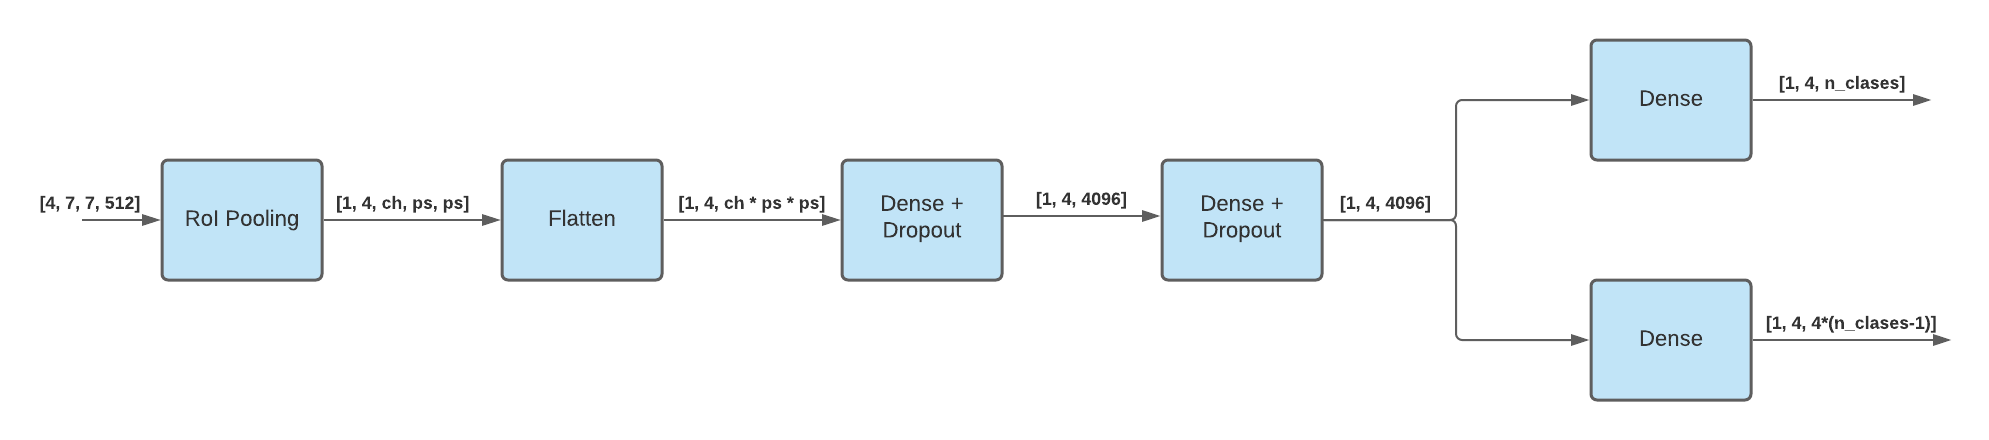

## <font color='green'>**Pregunta 2.**</font> 
Ejecute las siguientes lineas, observando cuidadosamente que pasa con cada una de las formas de las entradas y la ultima capa obtenida. (Observe usando la función <font color='blue'>*summary.*</font>)

In [ ]:
from keras import applications

vgg_model = applications.VGG16(weights='imagenet', include_top=True)
vgg_model.summary()


553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
vgg_model = applications.VGG16(weights='imagenet', include_top=False)
vgg_model.summary()


58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [ ]:
from keras.layers import Input

vgg_model = applications.VGG16(weights='imagenet', include_top=False, input_tensor = Input(shape=(160, 160, 3)) )
vgg_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

<font color='green'>¿Cuales son las diferencias entre los tres modelos?¿En que caso se debe usar cada uno de los 3 modelos?</font>

**Para el primer modelo:**

`vgg_model = applications.VGG16(weights='imagenet', include_top=True)`

Se establece que se usará un modelo entrenado VGG16 con el dataset ImageNet y que traiga su "top", es decir, su cabeza clasificadora o capas fully-connected. En el summary, este modelo especifica el tamaño de la imagen de entrada `[224, 224, 3]` debido a que al tener su cabeza clasificadora, las imágenes DEBEN ser del tamaño especificado anteriormente. El modelo dice la dimension de la imagen y las características a lo largo de toda la red. Este modelo puede ser usado para *tareas* de clasificación con imágenes contenidas en el imagenet o fine-tuning utilizando un nuevo set de imágenes, re-entrenando la cabeza clasificadora pero dejando intacto los pesos de las capas convolucionales.

**Para el segundo modelo:**

`vgg_model = applications.VGG16(weights='imagenet', include_top=False)`

Igual al anterior, se usará un modelo de VGG16 entrenado con el dataset de ImageNet pero en esta ocasión, sin su cabeza clasificadora o capas fully-connected. Lo anterior significa que el modelo únicamente traerá sus capas convolucionales. Esto se traduce en que ahora el summary no muestra la dimensión de la imagen y caracterísicas a lo largo del mismo. Este modelo puede ser usado para tareas de style-transfer, ya que, esta es una tarea que requiere únicamente los pesos pre-entrenados de un modelo convolucional. De igual modo, también se puede utilizar para tareas de fine-tuning donde el usuario definirá a su gusto un imagen con tamaño diferente a `[224, 224]` como entrada y por ende, una nueva capa clasificadora que permitirá re-entrenar el modelo con un nuevo set de imágenes de diferente tamaño al que fue entrenado originalmente. 

**Para el tercer modelo:**

`vgg_model = applications.VGG16(weights='imagenet', include_top=False, input_tensor = Input(shape=(160, 160, 3)) )`

Para este último caso, el modelo fue entrenado igual que los dos anteriores y viene sin su cabeza clasificadora. Sin embargo, se definió un tamaño de imagen de entrada de `[160, 160, 3]`, razón por la cual el summary muestra el tamaño de imagen y features a lo largo de todo el summary. Este modelo puede ser usado para tareas de clasificación con imágenes de tamaño igual al predefinido. No obstante, el usuario deberá crear su propia cabeza clasificatoria y reentrenarlo (fine-tuning) con un nuevo conjunto de imágenes que cumplan con la dimensión de entrada del modelo.

**Nota**: Los 3 modelos anteriore pueden ser utilizados en tareas de clasificación teniendo en cuenta las recomendaciones dadas anteriormente. De igual modo, se pueden extender para tareas de detección e incluso segmentación.

## <font color='green'>**Pregunta 3.**</font> 
A continuación se ha utilizado el concepto de <font color='blue'>*Transfer Learning*</font> para usar algunas de las capas del modelo pre-entrenado <font color='blue'>*VGG16*</font> con imagenet. A continuación usted encontrará el código para transferir algunas de las capas a un nuevo modelo.

<font color='green'>Comente linea por linea el siguiente código</font>

<font color='green'>Entrene este nuevo modelo, para hacer predicciones sobre el dataset de prueba dado en el laboratorio 2. Muestre los resultados obtenidos </font>

In [ ]:
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout,GlobalAveragePooling2D,BatchNormalization
from keras import applications
# https://github.com/sayakpaul/Transfer-Learning-with-CIFAR10/blob/master/CIFAR10_VGG16_Transfer_Learning_Classifier.ipynb

# Se carga el modelo VGG pre-entrenado con ImageNet y se establece un tamaño de entrada de la imagen de [160, 160, 3]
vgg_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3)) # (160, 160, 3)

# Diccionario con el nombre de cada una de las capas convolucionales en el modelo VGG
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Asigna a la variable X la salida de la capa convolucional block2_pool de VGG16
#x = layer_dict['block2_pool'].output
x = vgg_model.get_layer('block3_pool').output

# Pasa la salida de la anterior capa por una Conv2d de 64 canales y confiltros 3x3
#x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(x)
# Hace max pooling de la anterior convolucion
#x = MaxPooling2D(pool_size=(2, 2))(x)

# Aplana el anterior resultado
#x = Flatten()(x)

# se adiciona el GlobalAveragePooling2D que permite representar toda la capa Conv por un valor 
# promedio y para luego alimentar el valor promedio de todos los filtros a la siguiente capa Dense 
x = GlobalAveragePooling2D()(x)
# tambien se adiciona el BatchNormalization, que permite transformar los valores
# tal que la media es cercana a 0 y la desviacion estandar cercana a 1.
x= BatchNormalization()(x)

# Pasa el resultado aplanado por dos capas fully connected con 256 unidades y función de activación ReLU
x = Dense(256, activation='relu')(x) 
x = Dense(256, activation='relu')(x)  
# Dropea el 50% de las neuronas de la capa fully connected
x = Dropout(0.5)(x)
# Genera la capa de salida fully connected con 10 neuronas de salida, una para cada clase del CIFAR 10
x = Dense(10, activation='softmax')(x)

from keras.models import Model
# Se genera un nuevo modelo donde la entrada es la misma entrada definida al VGG16 y la salida son las operaciones
# definidas anteriormente
custom_model = Model(vgg_model.input, x)
# Congela todos los pesos de la VGG16, es decir, solo se entrenan las nuevas capas creadas
# Esto se hace para mantener los pesos ya entrenados con ImageNet y hacer fine-tuning
for layer in vgg_model.layers:  
  layer.trainable = False

# Compila el nueva modelo utilizando categorical_crossentropy(labels deben estar como un vector de one-hot),
# Con el optimizador RMSprop y se utilizará el accuracy como métrica de desempeño
custom_model.compile(loss='categorical_crossentropy',
 optimizer='rmsprop',
 metrics=['accuracy'])

custom_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [ ]:
import numpy as np
import cv2
import scipy as sp
import tensorflow as tf
import tensorflow.keras.layers as LK 
import tensorflow.keras.models as MK 
from keras.utils import np_utils
from keras.applications.vgg16 import preprocess_input

#Loading dataset
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test,y_test)= cifar10.load_data() 

#se realiza un resize de las imagenes de 32 a 48, debido a que en algunos textos
#afirman que la entrada de la VGG16 no debe ser menor a 48x48  
x_train =  np.array([cv2.resize(r, (48, 48), interpolation = cv2.INTER_AREA) for r in x_train])
x_test =  np.array([cv2.resize(r, (48, 48), interpolation = cv2.INTER_AREA) for r in x_test])

# Normalizacion usando preporcess_input funcion de keras para vgg16
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

# Labels deben estar codificados como one-hot encoding
y_train_cat = np_utils.to_categorical(y_train, 10)
y_test_cat = np_utils.to_categorical(y_test, 10)

In [ ]:
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1)
test_datagen = ImageDataGenerator()
datagen.fit(x_train)
iterator = datagen.flow(x_train, y_train_cat, batch_size=64)
iterator_test = datagen.flow(x_test, y_test_cat, batch_size=64)
muestras = x_train.shape[0] // 64 

# fits the model on batches with real-time data augmentation:
history = custom_model.fit(iterator, steps_per_epoch = muestras, epochs=10, verbose = 1, validation_data = iterator_test)
loss_aug,acc_aug= custom_model.evaluate(x_test, y_test_cat, verbose=1)
print("Loss:{0} - Accuracy:{1}".format(loss_aug,acc_aug) ) 

Epoch 1/10
781/781 [==============================] - 47s 56ms/step - loss: 1.3500 - accuracy: 0.5221 - val_loss: 0.8750 - val_accuracy: 0.6880
Epoch 2/10
781/781 [==============================] - 44s 56ms/step - loss: 0.9432 - accuracy: 0.6719 - val_loss: 0.8176 - val_accuracy: 0.7108
Epoch 3/10
781/781 [==============================] - 43s 56ms/step - loss: 0.8826 - accuracy: 0.6951 - val_loss: 0.8078 - val_accuracy: 0.7148
Epoch 4/10
781/781 [==============================] - 44s 56ms/step - loss: 0.8463 - accuracy: 0.7082 - val_loss: 0.8010 - val_accuracy: 0.7220
Epoch 5/10
781/781 [==============================] - 43s 56ms/step - loss: 0.8327 - accuracy: 0.7108 - val_loss: 0.7886 - val_accuracy: 0.7290
Epoch 6/10
781/781 [==============================] - 44s 56ms/step - loss: 0.7978 - accuracy: 0.7229 - val_loss: 0.7791 - val_accuracy: 0.7384
Epoch 7/10
781/781 [==============================] - 43s 56ms/step - loss: 0.7924 - accuracy: 0.7313 - val_loss: 0.7910 - val_accuracy:

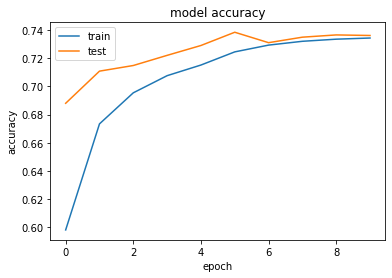

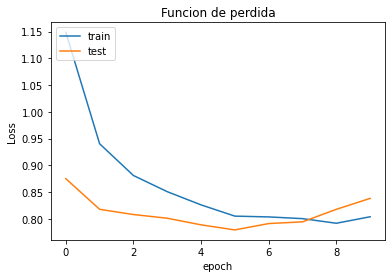

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Funcion de perdida')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import os
import cv2
import numpy as np

def load_img(dir_path,filesnames, size):
  #filesnames = os.listdir(dir_path)
  sw ,sh = size
  images=[]
  for file in filesnames:
    img = cv2.imread(os.path.join(dir_path, file))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    aspect_ratio = w/h  
    
    #para conservar el aspect ratio se calcula un pad dependiendo la proporcion
    if aspect_ratio > 1: 
    # quiere decir que la imagen es alargada horizontalmente y necesita pad arriba y abajo
      new_w = sw
      new_h = np.round(sw/aspect_ratio).astype(int)
      pad_vert = (sh-new_h)/2
      pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
      pad_left, pad_right = 0, 0
    elif aspect_ratio < 1: 
    # quiere decir que la imagen es alargada verticalmente y necesita pad a izquierda y derecha
      new_h=sh
      new_w = np.round(sh*aspect_ratio).astype(int)
      pad_horz = (sw-new_w)/2
      pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
      pad_top, pad_bot = 0, 0
    else: # si la imagen es cuadrada
      new_h, new_w = sh, sw
      pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    resized_img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
    
    #resized_img = resized_img.astype('float32')
    #resized_img = (resized_img-resized_img.min())/(resized_img.max()-resized_img.min()) #Normalizando
    #resized_img =  preprocess_input(resized_img)
    resized_img = cv2.copyMakeBorder(resized_img, pad_top, pad_bot, pad_left, pad_right, cv2.BORDER_REPLICATE) # BORDER_REPLICATE  BORDER_REFLECT
    
    images.append(resized_img) 
  
  return images

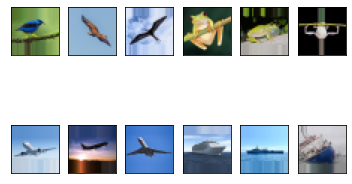

In [ ]:
import matplotlib.pyplot as plt
import cv2
# direccion o nombre de la carpeta con imagenes de prediccion
dir= 'dataset_prediccion'
# se cargan las imagenes en orden para poder calcular el accuracy
filesnames = ['bird1.jpg',
              'bird2.jpg',
              'bird3.jpg',
              'frog1.jpg',
              'frog2.jpg',
              'frog3.jpg',
              'plane1.jpg',
              'plane2.jpg',
              'plane3.jpg',
              'ship1.jpg',
              'ship2.jpg',
              'ship3.jpg']


images = load_img(dir,filesnames,(32,32))
for i in range(12):
    plt.subplot(2,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
plt.show()

() --> True label


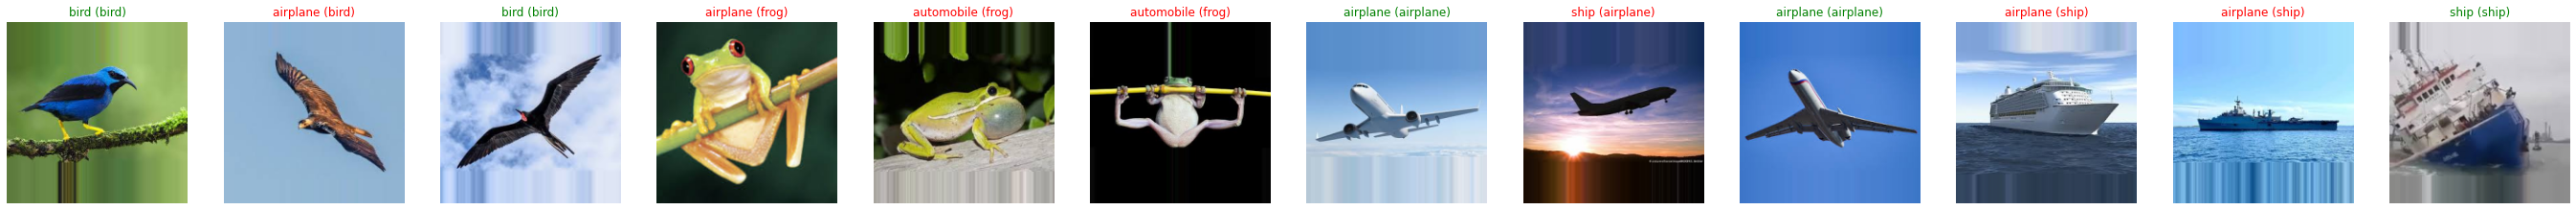

The accuracy with the new images is: 0.4166666666666667
The number of new images well classified are:  5


In [ ]:
dir= 'dataset_prediccion'
images = load_img(dir,filesnames,(48,48))
b_img = load_img(dir,filesnames,(200,200))

etiquetas = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
true_labels = ['bird', 'bird', 'bird', 'frog', 'frog', 'frog',  'airplane', 'airplane','airplane', 'ship','ship', 'ship',]

pred_labels = []
_, axes = plt.subplots(nrows=1, ncols=12, figsize=(48, 48))
print('() --> True label')
for ax, image, label, i in zip(axes, images, true_labels,range(len(images))):
  img = images[i].reshape(-1,48,48,3) #Cargue las imagenes y realiceles el pre-procesamiento necesario.
  img = preprocess_input(img)
  resultado = custom_model.predict(img)
  pred_labels.append(str(etiquetas[resultado.argmax()]))
  ax.set_axis_off()
  ax.imshow(cv2.cvtColor(b_img[i], cv2.COLOR_BGR2RGB))
  ax.set_title("{} ({})".format(str(etiquetas[resultado.argmax()]), label),
                 color=("green" if str(etiquetas[resultado.argmax()])==label else "red"))
plt.show()
true_pred = sum(1 for x,y in zip(pred_labels, true_labels) if x == y) 
print('The accuracy with the new images is: {}'.format(true_pred/ float(len(true_labels))))
print('The number of new images well classified are: ',true_pred)

## <font color='green'>**Pregunta 4.**</font> 
Nosotros hemos creado modelos de CNN's usando el método <font color='blue'>*secuencial*</font>. Sin embargo en el codigo de FasterRCNN  usan algunas veces el método <font color='blue'>*Subclase*</font>,como e.g, en class   <font color='blue'>*RoiPoolingConv()*</font>.

A continuación se da un ejemplo sencillo de la creación de una MLP usando el método <font color='blue'>*Subclase*</font> 


```
import tensorflow as tf

# Clase para crear el modelo a partir del método subclase
class MiModelo(tf.keras.Model):
    # Constructor de la clase
    def __init__(self):
      # Inicializa el constructor de la clase tf.keras.Model con super
      super(MiModelo, self).__init__()
      # Crea una capa dense de 4 unidades con activación RELU
      self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
      # Crea una capa dense de 5 unidades con activación softmax
      self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)

    # Método para hacer el feedforward de la red y especificar como esta será alimentada
    def call(self, inputs):
      # Pase las entrada por la primera capa dense
      x = self.dense1(inputs)
      # Pase el resultado de la primera capa dense por la segunda capa dense y retorne el resultado
      return self.dense2(x)
# Cree el modelo
modelo = MiModelo()
```



<font color='green'>Comente linea por linea el código anterior.

<font color='green'>Escriba la CNN básica de 3 bloques con metodo de regularización Dropout, descrita en el Laboratorio 2, usando el método Subclase. 

Imprima (summary) el modelo usando el método secuencial y el modelo usando el método Subclase (deben ser idénticos). </font>



In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as LK 
import tensorflow.keras.models as MK 
from keras.optimizers import SGD

class CNN(tf.keras.Model):
  def __init__(self):
    # Init super
    super(CNN, self).__init__()
    # Initialization of first chunk of conv layers
    self.conv1 = LK.Conv2D(32,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')
    self.conv2 = LK.Conv2D(32,(3,3),padding='same', kernel_initializer='he_normal', activation='relu') 
    self.pool1 = LK.MaxPool2D((2,2),(2,2))
    self.drop1 = LK.Dropout(0.25)
    # Initialization of second chunk of conv layers
    self.conv3 = LK.Conv2D(64,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')
    self.conv4 = LK.Conv2D(64,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')
    self.pool2 = LK.MaxPool2D((2,2),(2,2))
    self.drop2 = LK.Dropout(0.25)
    # Initialization of thirf chunk of conv layers
    self.conv5 = LK.Conv2D(128,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')
    self.conv6 = LK.Conv2D(128,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')
    self.pool3 = LK.MaxPool2D((2,2),(2,2))
    self.drop3 = LK.Dropout(0.25)
    # Flatten the output of the last conv layer
    self.flat =  LK.Flatten()
    # Create a dense layer of 128 units
    self.FC3 = LK.Dense(128,activation='relu', kernel_initializer='he_normal')
    # Regularize the 25% with dropout
    self.drop4 = LK.Dropout(0.25)
    # Initialize a final dense layer of 10 units with activatin softmax
    self.outputs = LK.Dense(10,activation='softmax')

  # Method to feedforward the inputs through the network
  def call(self, inputs):
    # First block of convolutions
    x = self.conv1(inputs)
    x = self.conv2(x)
    x = self.pool1(x)
    x = self.drop1(x)
    # Second block of convolutions
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.pool2(x)
    x = self.drop2(x)
    # Third block of convolutions
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.pool3(x)
    x = self.drop3(x)
    # Fully connected part
    x = self.flat(x)
    x = self.FC3(x)
    x = self.drop4(x)
    x = self.outputs(x)
    # return the output of the final dense layer
    return x

  # Override summary method as I was getting not getting the proper dimension while printing summary
  def summary(self, input_shape):
    x = LK.Input(shape=input_shape)
    model = tf.keras.Model(inputs=[x], outputs=self.call(x))
    return model.summary()

# Building the model
input_shape = (32, 32, 3) # Same input defined in the sequential method
class_model = CNN()
# As summarry method was override in order to print the proper image dimension, now the input_shape must be specified
# to thoroughly print the model's summary
class_model.summary(input_shape)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_87 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 16, 16, 64)        3692

In [ ]:
inputs = LK.Input(shape=(32,32,3)) 
conv1 = LK.Conv2D(32,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(inputs) 
conv2 = LK.Conv2D(32,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(conv1) 
pool1 = LK.MaxPool2D((2,2),(2,2))(conv2)
drop1 = LK.Dropout(0.25)(pool1)

conv3 = LK.Conv2D(64,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(drop1) 
conv4 = LK.Conv2D(64,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(conv3) 
pool2 = LK.MaxPool2D((2,2),(2,2))(conv4) 
drop2 = LK.Dropout(0.25)(pool2)

conv5 = LK.Conv2D(128,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(drop2) 
conv6 = LK.Conv2D(128,(3,3),padding='same', kernel_initializer='he_normal', activation='relu')(conv5) 
pool3 = LK.MaxPool2D((2,2),(2,2))(conv6)
drop3 = LK.Dropout(0.25)(pool3) 

flat =  LK.Flatten()(drop3) 
FC3 = LK.Dense(128,activation='relu', kernel_initializer='he_normal')(flat)
drop4 = LK.Dropout(0.25)(FC3)
outputs = LK.Dense(10,activation='softmax')(drop4) 

mb_dropout = MK.Model(inputs,outputs) 
mb_dropout.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 16, 16, 64)        3692